In [2]:
import os, sys
currentdir = os.path.dirname(os.path.abspath(os.getcwd()))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir) 
sys.path.insert(0, parentdir) 
sys.path.insert(0, currentdir + "\Code") 

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib import rc
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import LinearLocator

from scipy.integrate import odeint, DOP853, solve_ivp
from itertools import chain, combinations, permutations

from ring_functions import *

cmap = 'gray'
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# circle_in_vectorspace = 

# #create points on hypersphere as:
# 1. take p=[1, 0, ... 0]
# 2. rotate point(s) along next axis ????


import math


def fibonacci_sphere(samples=1000):

    points = []
    phi = math.pi * (math.sqrt(5.) - 1.)  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append((x, y, z))

    return points




def uniform_hypersphere_lattice(n_points, n_dim):
    """
    Generate a uniform lattice of points on an N-dimensional hypersphere.
    
    Parameters:
        n_points (int): The number of lattice points to generate.
        n_dim (int): The number of dimensions of the hypersphere.
    
    Returns:
        A numpy array of shape (n_points, n_dim) representing the lattice points.
    """
    points = np.zeros((n_points, n_dim))
    delta = 2.0 / n_points
    for i in range(n_points):
        r = 1
        phi = i * delta * 2 * np.pi
        x = r * np.cos(phi)
        y = r * np.sin(phi)
        points[i, 0] = x
        points[i, 1] = y
        for j in range(2, n_dim):
            points[i, j] = points[i, j-2] * np.cos(delta * np.pi) + \
                           points[i, j-1] * np.sin(delta * np.pi)
    return points

## Helper functions

In [5]:
# symmetric cosine weight matrix W sym jk = JI + JE cos(theta_j - theta_K)
# where JE and JI respectively control the strength of the tuned and untuned components of recurrent connectivity between neurons with preferred headings theta_j and theta_k.

# For a network of size N , there are N 3 such “optimal” values of local excitation J*E

# The parameters (JI, JE) can be set such that this system will generate a population profile that qualitatively looks like a discretely sampled “bump” of activity.
# (JI, JE) are within the subset  \Omega = \OmegaJI\times\OmegaJE \subset (−1, 1) \times (2,1)

def get_noorman_symmetric_weights(N, J_I = 1, J_E = 1):
    # W sym jk = JI + JE cos(theta_j - theta_K)
    x = np.arange(0,N,1)
    row = J_I + J_E*np.cos(2*np.pi*x/N)
    W = scipy.linalg.circulant(row)
    return W


# W asym jk =sin(theta_j - theta_k)
def get_noorman_asymmetric_weights(N):
    # W asym jk =sin(theta_j - theta_k)
    x = np.arange(0,N,1)
    row = np.sin(2*np.pi*x/N)
    W = scipy.linalg.circulant(row)
    return W

def noorman_jacobian(x, W_sym):
    N = W_sym.shape[0]
    
    r = np.where(x>0)
    W_sub = np.zeros((N,N))
    W_sub[:,r] = W_sym[:,r]
    J = -np.eye(N)
    J += W_sub/N
    return J

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def noorman_fixed_points(W_sym, c_ff):
    """
    Takes as argument all the parameters of the recurrent part of the model (W_sym, c_ff)
    \dot x = -x + 1/N W_sym ReLU(x) + c_ff = 0
    """
    fixed_point_list = []

    N = W_sym.shape[0]
    subsets = powerset(range(N))
    for support in subsets:
        if support == ():
            continue
        r = np.array(support)
        
        W_sub = np.zeros((N,N))
        W_sub[:,r] = W_sym[:,r]
        A = W_sub/N - np.eye(N)
        fixed_point = -np.dot(np.linalg.inv(A), np.ones(N)*c_ff)
        
        #check true fixed point
        negativity_condition = True
        # print(r, [item for item in range(N) if item not in r])
        for i in r:
            if fixed_point[i] <= 0:
                negativity_condition = False
        for i in [item for item in range(N) if item not in r]:
            if fixed_point[i] >= 0:
                negativity_condition = False
        
        if negativity_condition:
            fixed_point_list.append(fixed_point)
        
    fixed_point_array = np.array(fixed_point_list)
    return fixed_point_array

def noorman_speed(x,tau,transfer_function,W_sym,W_asym,c_ff,N):
    f_x = noorman_ode(0,x,tau,transfer_function,W_sym,W_asym,c_ff,N)
    return np.linalg.norm(f_x)

In [6]:
def bump_perturbation(x, center, rotation_mat, amplitude, b=1):
    """
    Perturbation is composed of parallel vector field 
    with the location given by center, 
    the norm of the vectors determined by a bump function
    and the orientation given by theta
    
    x.shape = (Numberofpoints,N)
    rotation_mat: orientation of perturbation
    implemented for N-dimensional systems
    """
    N = x.shape[0]
    vector_bump = np.zeros(N)
    vector_bump[0] = 1.
    rotation_mat = special_ortho_group.rvs(N)
    vector_bump = np.dot(vector_bump, rotation_mat)
    vector_bump = np.multiply(vector_bump, bump_function(x, center=center, amplitude=amplitude, b=b))
    
    return vector_bump



def noorman_ode_pert(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N,center,rotation_mat,amplitude,b):
    """
    create ODE for Noorman ring attractor with a local bump perturbation
    center,rotation_mat,amplitude,b are set
    """
    vector_bump = bump_perturbation(x, center, rotation_mat, amplitude, b)
    noor = noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N)
    return noor + vector_bump

def noorman_ode_Npert(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N,Nbumps):
    """
    create ODE for Noorman ring attractor with Nbumps local bump perturbations
    for each bump: center,rotation_mat,amplitude,b are random
    """
    noorode = noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N)
    for bi in range(Nbumps):
        bump_i = np.random.randint(bumps.shape[0]) 
        roll_j = np.random.randint(N)
        center = np.roll(bumps[:,bump_i], roll_j).copy()
        rotation_mat = special_ortho_group.rvs(N)
        amplitude = np.random.rand()
        b = np.random.rand()
        noorode += bump_perturbation(x, center, rotation_mat, amplitude, b)

    return noorode

In [7]:
# we will take phi(·) to be threshold linear

def v_in(t):
    return 0

def noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N):
    """Differential equation of head direction network in Noorman et al., 2022. 
    tau: integration constant
    transfer_function: each neuron transforms its inputs via a nonlinear transfer function
    W_sym, W_asym: symmetric and asymmetric weight matrices
    v_in: input
    c_ff: a constant feedforward input to all neurons in the network
    N: number of neurons in the network
    """

    return (-x + np.dot(W_sym+v_in(t)*W_asym, transfer_function(x))/N + c_ff)/tau

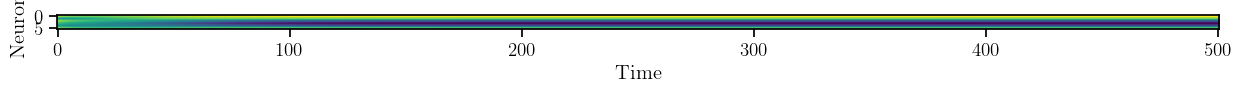

In [58]:
tau = 1
transfer_function = ReLU
N = 6
J_I = -2.4
J_E = 4
W_sym = get_noorman_symmetric_weights(N, J_I, J_E)
W_asym = get_noorman_asymmetric_weights(N)
c_ff = 1.

maxT = 25
t = np.linspace(0, maxT, 501)
y0 = np.random.uniform(0,1,N)

sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N]),dense_output=True)

sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})
fig, axs = plt.subplots(1, 1, figsize=(15, 8), sharex=True, sharey=True)
axs.imshow(sol.sol(t))
axs.set_xlabel("Time")
axs.set_ylabel("Neurons");

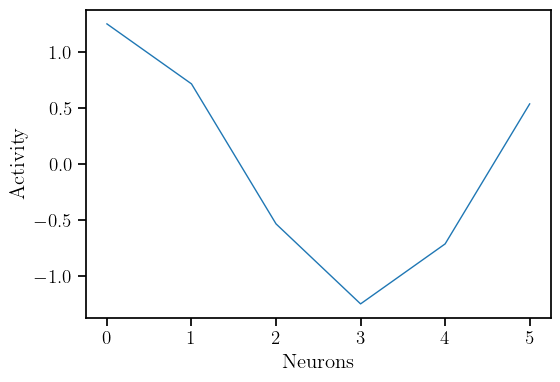

In [59]:
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.plot(sol.sol(t)[:,-1])
ax.set_ylabel("Activity")
ax.set_xlabel("Neurons");

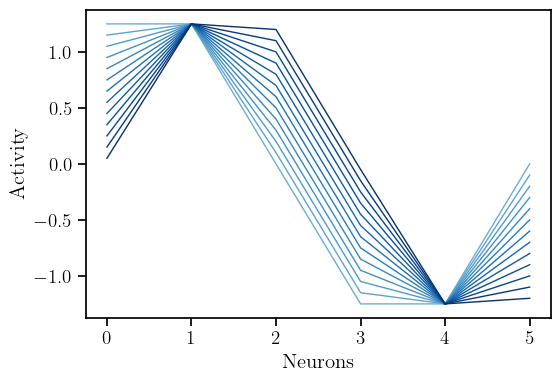

In [60]:
m = np.max(sol.sol(t))
# m #round? what should the maximum be according to the paper?

x = np.arange(0, m, 0.1)
bumps = np.array([m-x,m*np.ones(x.shape),x,x-m,-m*np.ones(x.shape),-x])

fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
colors = plt.cm.Blues(np.linspace(0.5,1,x.shape[0]))
ax.set_prop_cycle('color', colors)

for bump_i in range(bumps.shape[1]):
    ax.plot(bumps[:,bump_i])
    
ax.set_ylabel("Activity")
ax.set_xlabel("Neurons");

# plt.savefig(currentdir+"/Stability/figures/noorman_ring_side.pdf", bbox_inches="tight")

In [61]:
corners = []
 
for support_j in range(N):
    corners.append(np.roll(np.array([m,m,0,-m,-m,0]), support_j))
corners = np.array(corners)

In [62]:
maxT = 200
t = np.linspace(0, maxT, 501)

y0 = np.random.uniform(0,1,N)
sols = np.zeros((x.shape[0], N, t.shape[0], N))
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        y0 = np.roll(bumps[:,bump_i], support_j)
        sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N]),dense_output=True)
        sols[bump_i,support_j,...] = sol.sol(t).T

[]

<Figure size 500x500 with 0 Axes>

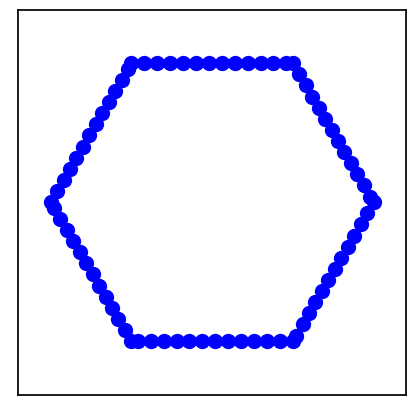

In [63]:
N_points = bumps.shape[0]*bumps.shape[1]
sols = sols.reshape((N_points, -1, N))
pca = sklearn.decomposition.PCA(n_components=2)
X_proj2 = pca.fit_transform(sols[:,0,:]) 

plt.figure(figsize=(5,5))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
ax.plot(X_proj2[:,0], X_proj2[:,1], '.b', label="Original attractor", alpha=1., markersize=20)
ax.set(xlim=(-3, 3), ylim=(-3,3))
ax.set_xticks([])
ax.set_yticks([])

# plt.savefig(currentdir+"/Stability/figures/noorman_ring_activity_pert2.pdf", bbox_inches="tight")
# plt.savefig(currentdir+"/Stability/figures/noorman_ring_activity_pert2.png", bbox_inches="tight")
# plt.show()

### Perturbations

In [111]:
#To all connections
eps = np.random.uniform(-1,1,(N,N))/10.

#To a single connection
#non-self
# eps = np.zeros((N,N))
# eps[0,1] = 1/100.

# ## Self
# eps = np.zeros((N,N))
# eps[0,0] = 1/100.

In [112]:
# np.savetxt("eps_N6_2stab_2sadd.csv", eps, delimiter=",")

<Figure size 500x500 with 0 Axes>

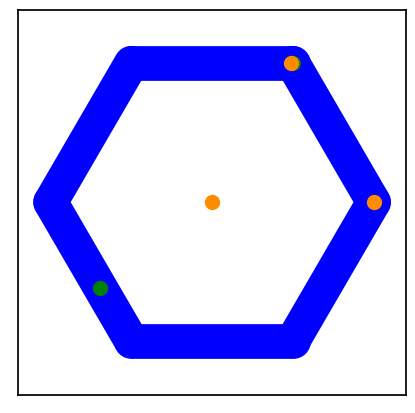

In [113]:
eps = np.random.uniform(-1,1,(N,N))/1000.

fixed_points = noorman_fixed_points(W_sym+eps, c_ff)
N_points = bumps.shape[0]*bumps.shape[1]

corners_proj2 = pca.transform(corners)
fixed_points_proj2 = pca.transform(fixed_points) 

plt.figure(figsize=(5,5))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)

for f_i, fixed_point_p in enumerate(fixed_points_proj2):
    fixed_point = fixed_points[f_i]
    eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym+eps))
    if np.all(np.real(eigenvalues)<0):
        ax.plot(fixed_point_p[0], fixed_point_p[1], '.g', label="Analytical", zorder=99, alpha=1., markersize=20)
    else:
        ax.plot(fixed_point_p[0], fixed_point_p[1], '.', color='darkorange', label="Analytical", zorder=99, alpha=1., markersize=20)

for i in range(N):
    ax.plot([corners_proj2[i-1,0], corners_proj2[i,0]],
            [corners_proj2[i-1,1], corners_proj2[i,1]],
            'b', label="Original attractor", zorder=0, alpha=1., linewidth=25, 
            solid_capstyle='round')

ax.set(xlim=(-3, 3), ylim=(-3,3))
ax.set_xticks([])
ax.set_yticks([])

original = mlines.Line2D([], [], color='b', marker='.', linestyle='None',
                          markersize=1, label="Original attractor")
stable = mlines.Line2D([], [], color='r', marker='.', linestyle='None',
                          markersize=5, label="Stable")

# plt.savefig(currentdir+"/Stability/figures/noorman_ring_pert_1stab_1sadd.pdf", bbox_inches="tight")
# plt.savefig(currentdir+"/Stability/figures/noorman_ring_pert_1stab_1sadd.png", bbox_inches="tight")
# plt.show()

### Finding connecting orbits

In [ ]:
N_fixed_points = fixed_points.shape[0]
maxT = 200000
t = np.linspace(0, maxT, 50001)

n_perts = 10
sols = np.zeros((N_fixed_points, n_perts, t.shape[0], N))
for f_i, fixed_point in enumerate(fixed_points):
    for i in range(n_perts):
        y0 = fixed_point + np.random.normal(0,.01,(N))
        sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym+eps, W_asym, c_ff, N]),dense_output=True)
        sols[f_i,i,...] = sol.sol(t).T

In [ ]:
sols = sols.reshape((N_fixed_points*n_perts*sol.sol(t).shape[1], N))
X_proj2 = pca.transform(sols[:,:]) 

plt.figure(figsize=(5,5))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)

ax.plot(X_proj2[:,0], X_proj2[:,1], '.k', label="", alpha=1., markersize=5, zorder=99)

for f_i, fixed_point_p in enumerate(fixed_points_proj2):
    fixed_point = fixed_points[f_i]
    eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym+eps))
    if np.all(np.real(eigenvalues)<0):
        ax.plot(fixed_point_p[0], fixed_point_p[1], '.g', label="Analytical", zorder=99, alpha=1., markersize=20)
    else:
        ax.plot(fixed_point_p[0], fixed_point_p[1], '.', color='darkorange', label="Analytical", zorder=99, alpha=1., markersize=20)

for i in range(N):
    ax.plot([corners_proj2[i-1,0], corners_proj2[i,0]],
            [corners_proj2[i-1,1], corners_proj2[i,1]],
            'b', label="Original attractor", zorder=0, alpha=1., linewidth=25, 
            solid_capstyle='round')
    

ax.set(xlim=(-3, 3), ylim=(-3,3))
ax.set_xticks([])
ax.set_yticks([])

original = mlines.Line2D([], [], color='b', marker='.', linestyle='None',
                          markersize=1, label="Original attractor")
stable = mlines.Line2D([], [], color='r', marker='.', linestyle='None',
                          markersize=5, label="Stable")

# plt.savefig(currentdir+"/Stability/figures/noorman_ring_pert_1stab_1sadd.pdf", bbox_inches="tight")
# plt.savefig(currentdir+"/Stability/figures/noorman_ring_pert_1stab_1sadd.png", bbox_inches="tight")
# plt.show()

In [137]:
maxT = 2*2000
t = np.linspace(0, maxT, 2*50001)

epssols = np.zeros((x.shape[0], N, t.shape[0], N))
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        y0 = np.roll(bumps[:,bump_i], support_j) 
        sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym+eps, W_asym, c_ff, N]),dense_output=True)
        epssols[bump_i,support_j,...] = sol.sol(t).T
        

<Figure size 500x500 with 0 Axes>

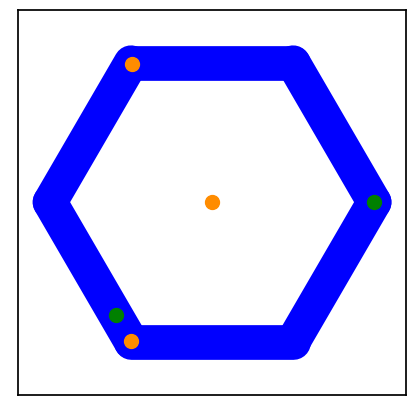

In [415]:
N_points = bumps.shape[0]*bumps.shape[1]
sols = sols.reshape((N_points, -1, N))
epssols_flat = epssols.reshape((N_points, -1, N))

# pca = sklearn.decomposition.PCA(n_components=2)
X_proj2 = pca.transform(sols[:,-1,:]) 
Xeps_proj2 = pca.transform(epssols_flat[:,-1,:]) 
Xeps_start_proj2 = pca.transform(epssols_flat[:,40,:]) 
corners_proj2 = pca.transform(corners)
fixed_points_proj2 = pca.transform(fixed_points) 

plt.figure(figsize=(5,5))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
# ax.plot(X_proj2[:,0], X_proj2[:,1], '.b', label="Original attractor", alpha=1., markersize=20)
# ax.plot(Xeps_proj2[:,0], Xeps_proj2[:,1], '.g', label="Stable", zorder=10, alpha=1., markersize=20)
# for i in range(1000):
#     Xeps_start_proj2 = pca.transform(epssols_flat[:,i*1,:]) 
    # ax.plot(Xeps_start_proj2[:,0], Xeps_start_proj2[:,1], '.g', zorder=9, alpha=1., markersize=9)
for f_i, fixed_point_p in enumerate(fixed_points_proj2):
    fixed_point = fixed_points[f_i]
    eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym+eps))
    if np.all(np.real(eigenvalues)<0):
        ax.plot(fixed_point_p[0], fixed_point_p[1], '.g', label="Analytical", zorder=99, alpha=1., markersize=20)
    else:
        ax.plot(fixed_point_p[0], fixed_point_p[1], '.', color='darkorange', label="Analytical", zorder=99, alpha=1., markersize=20)

# ax.plot(fixed_points_proj2[:,0], fixed_points_proj2[:,1], '.k', label="Analytical", zorder=99, alpha=1., markersize=9)
# for f_i, fixed_point in enumerate(fixed_points_proj2):
#     ax.text(fixed_point[0]*1.2, fixed_point[1]*1.2, str(f_i), color="black", fontsize=12)

# for i in [3,5]:
#     ax.plot(corners_proj2[i,0], corners_proj2[i,1], '.r', label="Unstable", zorder=9, alpha=1., markersize=20)

for i in range(N):
    ax.plot([corners_proj2[i-1,0], corners_proj2[i,0]],
            [corners_proj2[i-1,1], corners_proj2[i,1]],
            'b', label="Original attractor", zorder=0, alpha=1., linewidth=25, 
            solid_capstyle='round')

    

ax.set(xlim=(-3, 3), ylim=(-3,3))
ax.set_xticks([])
ax.set_yticks([])
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.),
          # fancybox=True, shadow=True, ncol=3, columnspacing=0.8, handletextpad=.3)

original = mlines.Line2D([], [], color='b', marker='.', linestyle='None',
                          markersize=1, label="Original attractor")
stable = mlines.Line2D([], [], color='r', marker='.', linestyle='None',
                          markersize=5, label="Stable")
# unstable = mlines.Line2D([], [], color='g', marker='.', linestyle='None',
#                           markersize=1, label="Unstable")

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.), fancybox=True, shadow=True, ncol=3, columnspacing=0.8, handletextpad=.3, 
#            handles=[original, stable])x

# plt.savefig(currentdir+"/Stability/figures/noorman_ring_pert_2stab_2sadd.pdf", bbox_inches="tight")
# plt.savefig(currentdir+"/Stability/figures/noorman_ring_pert_2stab_2sadd.png", bbox_inches="tight")
# plt.show()

##### Eigenvalues

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.set_prop_cycle(color=['k', 'crimson', 'b', 'orange', 'g'])
ax.set_prop_cycle(marker=['o', 'x'])

colors = ['g', 'r']

for f_i, fixed_point in enumerate(fixed_points):
    eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym+eps))
    # ax.scatter(np.real(eigenvalues), np.imag(eigenvalues), s=10*(N-f_i), zorder=f_i)
    if np.all(np.real(eigenvalues)<0):
        ax.scatter(np.real(eigenvalues), np.imag(eigenvalues), s=10*(N-f_i), zorder=f_i, color=colors[0])
    else:
        ax.scatter(np.real(eigenvalues), np.imag(eigenvalues), s=10*(N-f_i), zorder=f_i, color=colors[1])

In [235]:
def strictly_increasing(L):
    return all(x<y for x, y in zip(L, L[1:]))

def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

def check_all_trajs_non_decreasing(distances):
    non_decs = []
    for bump_i in range(bumps_per_side):
        for support_j in range(N):
            non_dec = non_decreasing(distances[bump_i, support_j, :])
            non_decs.append(non_dec)
    return np.all(non_decs)
# check_all_trajs_non_decreasing(distances)


In [295]:
for support_j_0 in range(N):
    y0 = corners_proj2[support_j_0,:]

    distances = np.zeros((bumps_per_side, N, epssols.shape[2]))
    for bump_i in range(bumps_per_side):
        for support_j in range(N):
            if bump_i==bump_i_0 and support_j==support_j_0:
                continue

            if not support_j == ((support_j_0-1)%N) and not support_j == ((support_j_0)%N):
                continue
            Xeps_proj2 = pca.transform(epssols[bump_i,support_j,:,:].reshape((-1, N))) 
            distances[bump_i, support_j, :] = np.linalg.norm(y0 - Xeps_proj2, axis=-1)

    print(check_all_trajs_non_decreasing(distances.astype(int)))
# for support_j in range(N):
#     plt.plot(distances[:,support_j,:].T)

False
False
False
False
False
True


In [1]:
# # for start_i in range(bumps_per_side*N):
# for support_j_0 in range(N):
#     for bump_i_0 in range(bumps_per_side):
#         if bump_i_0==0 or bump_i_0==bumps_per_side:
#             continue

#         y0 = pca.transform(epssols[bump_i_0,support_j_0,0,:].reshape((-1, N))) 

#         distances = np.zeros((bumps_per_side, N, epssols.shape[2]))
#         for bump_i in range(bumps_per_side):
#             for support_j in range(N):
#                 if bump_i==bump_i_0 and support_j==support_j_0:
#                     continue
#                 if support_j!=support_j_0:
#                     continue

#                 Xeps_proj2 = pca.transform(epssols[bump_i,support_j,:,:].reshape((-1, N))) 
#                 distances[bump_i, support_j, :] = np.linalg.norm(y0 - Xeps_proj2, axis=-1)
    
#         print(bump_i_0, support_j_0, check_all_trajs_non_decreasing(np.round(distances,2)))
        
# # bumps_per_side = x.shape[0]
# for bump_i_0 in range(bumps_per_side):
#     for support_j_0 in range(N):
#         y0 = np.roll(bumps[:,bump_i_0], support_j_0) 


#         distances = np.zeros((bumps_per_side, N, epssols.shape[2]))
#         for bump_i in range(bumps_per_side):
#             for support_j in range(N):


#                 distances[bump_i, support_j, :] = np.linalg.norm(y0 - epssols[bump_i,support_j,...], axis=-1)
        
#         print(check_all_trajs_non_decreasing(distances))

#### Distribution of topologies

In [498]:
from tqdm import tqdm

In [546]:
number_of_fixed_points = []

pert_size = 1e-5
for i in tqdm(range(100000)):
    
    #uniform in hypercube
    # eps = pert_size*np.random.uniform(-1,1,(N,N))
    
    #uniform in hypersphere
    vector_pert = np.zeros(N**2)
    vector_pert[0] = 1.
    rotation_mat = special_ortho_group.rvs(N**2)
    eps = pert_size*np.dot(vector_pert, rotation_mat).reshape((N,N))

    fixed_points = noorman_fixed_points(W_sym+eps, c_ff)
    # fixed_points = np.array(fixed_points)

#     corners_proj2 = pca.transform(corners)
#     fixed_points_proj2 = pca.transform(fixed_points) 

#     plt.figure(figsize=(5,5))
#     fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)

#     for f_i, fixed_point_p in enumerate(fixed_points_proj2):
#         fixed_point = fixed_points[f_i]
#         eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym+eps))
    number_of_fixed_points.append(fixed_points.shape[0]-1)

 52%|████████████████████████████████████▊                                  | 51841/100000 [1:07:55<1:03:05, 12.72it/s]

KeyboardInterrupt



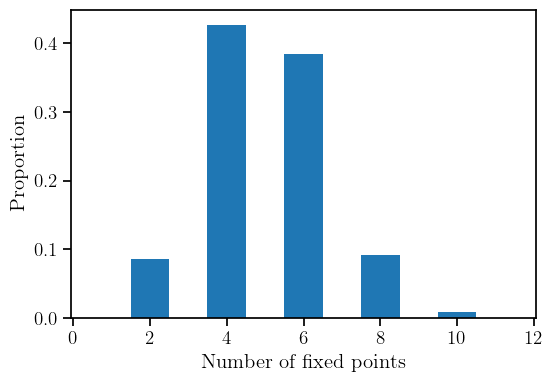

In [547]:
weights = np.ones_like(number_of_fixed_points)/float(len(number_of_fixed_points))

sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)

ax.set_ylabel("Proportion")
ax.set_xlabel("Number of fixed points");
ax.hist(number_of_fixed_points, bins=np.arange(.5, 12.5, 1), weights=weights);

plt.savefig(currentdir+"/Stability/figures/noorman_ring_spherepert{pert_size}_nfp_histogram.png", bbox_inches="tight")
plt.savefig(currentdir+"/Stability/figures/noorman_ring_spherepert{pert_size}_nfp_histogram.pdf", bbox_inches="tight")

(36,)

#### Bumps

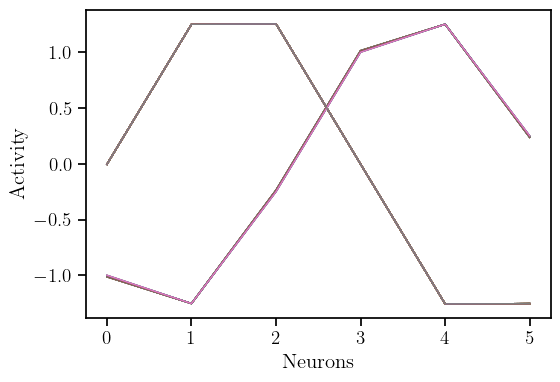

In [139]:
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        ax.plot(epssols[bump_i,support_j,-1,:])
ax.set_ylabel("Activity")
ax.set_xlabel("Neurons");

In [140]:
speed = np.linalg.norm(epssols[:,:,:-1,:]-epssols[:,:,1:,:],axis=3)

(13, 6, 100001)

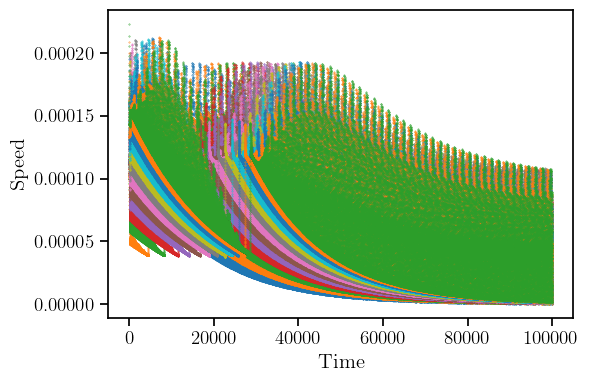

In [142]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
support_j = 4
for bump_i in range(x.shape[0]):
    # for support_j in range(0): #N
            # for t in range(1,100): #epssols.shape[2]
            ax.scatter(range(epssols.shape[2]-1), speed[bump_i,support_j,:], s=.1)
ax.set_ylabel("Speed")
ax.set_xlabel("Time");

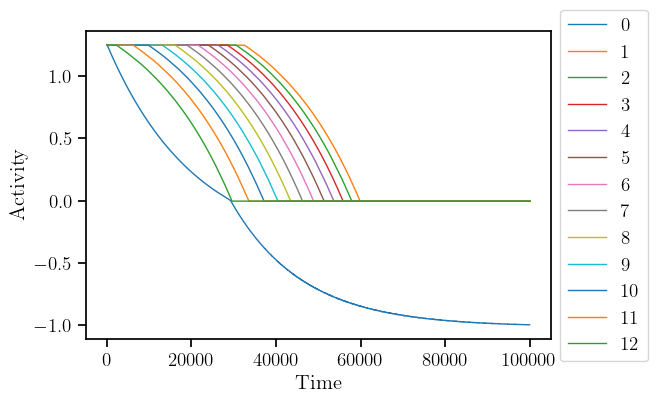

In [155]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
support_j = 5
for bump_i in range(x.shape[0]):
    # for support_j in range(0): #N
            # for t in range(1,100): #epssols.shape[2]
            ax.plot(epssols[bump_i,support_j,:,0], label=f'{bump_i}')
ax.set_ylabel("Activity")
ax.set_xlabel("Time");
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.1));

#### Eigenvalues of Jacobian

Text(0.5, 0, 'Re')

<Figure size 300x300 with 0 Axes>

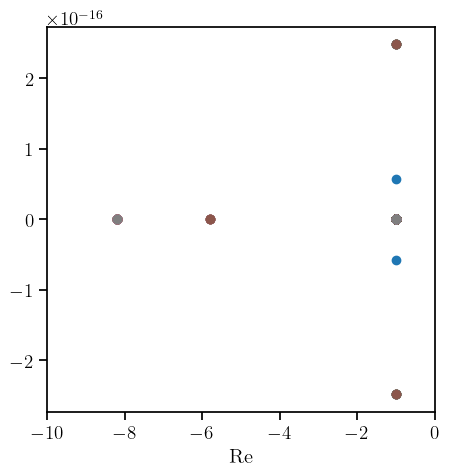

In [150]:
plt.figure(figsize=(3,3))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        eigenvalues, eigenvectors = scipy.linalg.eig(noorman_jacobian(epssols[bump_i,support_j,0,:], W_sym+eps))
        plt.scatter(np.real(eigenvalues), np.imag(eigenvalues))
plt.xlim([-10,0])
plt.xlabel("Re")

## Find fixed points through minimization of speed

In [14]:
# Nsamples = 10000
# fxd_points = np.zeros((Nsamples,N))
# for i in range(Nsamples):
#     x0 = np.random.uniform(-1,1,N)
#     res = minimize(noorman_speed, x0, method='Nelder-Mead', tol=1e-9, args=(tau,transfer_function,W_sym+eps,W_asym,c_ff,N))
#     fxd_points[i,:] = res.x
    
eps = np.zeros((N,N))
eps[0,1] = 1/100.

Nsamples_per_side = x.shape[0]
fxd_points = np.zeros((Nsamples_per_side*N,N))
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        x0 = np.roll(bumps[:,bump_i], support_j) 
        res = minimize(noorman_speed, x0, method='SLSQP', tol=5e-10, args=(tau,transfer_function,W_sym+eps,W_asym,c_ff,N))
        fxd_points[bump_i+Nsamples_per_side*support_j,:] = res.x

NameError: name 'pca' is not defined

<Figure size 500x500 with 0 Axes>

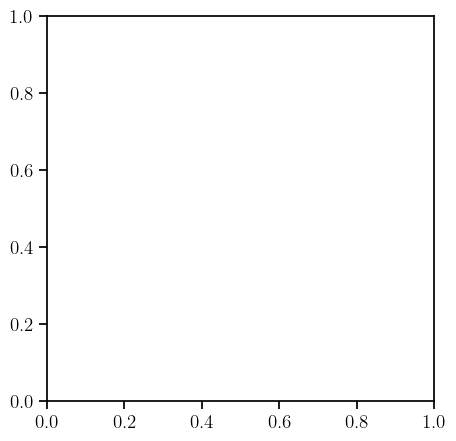

In [15]:
plt.figure(figsize=(5,5))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
u_fxd_points = np.unique(np.round(fxd_points, 6), axis=0)

u_fxd_points_proj2 = pca.transform(u_fxd_points) 
plt.scatter(u_fxd_points_proj2[:,0], u_fxd_points_proj2[:,1], color='r', label="Stable", zorder=10, alpha=1., s=5)

ax.set(xlim=(-3, 3), ylim=(-3,3))
ax.set_xticks([])
ax.set_yticks([])

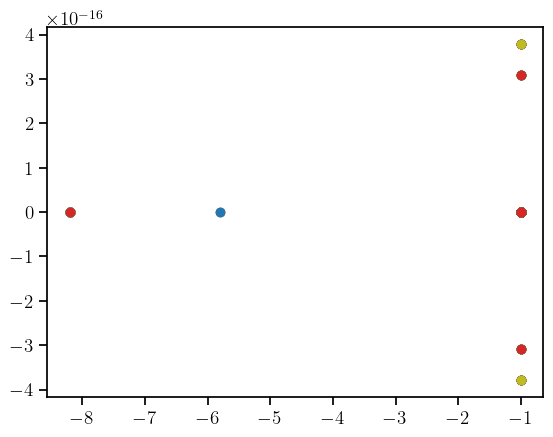

In [112]:
for i in range(u_fxd_points.shape[0]):
        eigenvalues, eigenvectors = scipy.linalg.eig(noorman_jacobian(u_fxd_points[i,:], W_sym+eps))
        plt.scatter(np.real(eigenvalues), np.imag(eigenvalues))

### The bump perturbations

In [371]:
rotation_mat = special_ortho_group.rvs(N)
#create a random point along the ring attractor by 
        #choosing a random bump
        #and roll with it
bump_i = np.random.randint(50, 60) 
roll_j = np.random.randint(N)
center = np.roll(bumps[:,bump_i], roll_j).copy()
amplitude = 2.
b = .1

In [372]:
m = np.max(sols)
m #round? what should the maximum be according to the paper?

x = np.arange(0, m, 0.01)
bumps = np.array([m-x,m*np.ones(x.shape),x,x-m,-m*np.ones(x.shape),-x])
x.shape[0]

126

In [373]:
maxT = 200
t = np.linspace(0, maxT, 501)
sols = np.zeros((x.shape[0], N, t.shape[0], N))
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        # print(bump_i, support_j)
        y0 = np.roll(bumps[:,bump_i], support_j)
        sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], t_eval=t, args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N]),dense_output=True)
        sols[bump_i,support_j,...] = sol.sol(t).T

In [374]:
epssols = np.zeros((x.shape[0], N, t.shape[0], N))
for bump_i in range(x.shape[0]):
    for support_j in range(N):
        # print(bump_i, support_j)
        y0 = np.roll(bumps[:,bump_i], support_j) 
        sol = solve_ivp(noorman_ode_pert, y0=y0,  t_span=[0,maxT], t_eval=t, args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N, center, rotation_mat, amplitude, b]),dense_output=True)
        epssols[bump_i,support_j,...] = sol.sol(t).T
        
# t = np.linspace(0, -1, 51)
# back_epssols = np.zeros((x.shape[0], N, t.shape[0], N))
# for bump_i in range(x.shape[0]):
#     for support_j in range(N):
#         y0 = np.roll(bumps[:,bump_i], support_j) 
#         sol = solve_ivp(noorman_ode_pert, y0=y0,  t_span=[0,-1], t_eval=t, args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N, center, rotation_mat, amplitude, b]),dense_output=True)
#         back_epssols[bump_i,support_j,...] = sol.sol(t).T

<Figure size 500x500 with 0 Axes>

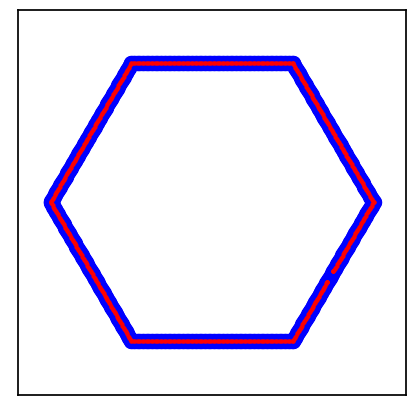

In [375]:
sols = sols.reshape((-1,t.shape[0], N))
epssols_flat = epssols.reshape((-1,t.shape[0], N))
# back_epssols_flat = back_epssols.reshape((-1,t.shape[0], N))

# pca = sklearn.decomposition.PCA(n_components=n_components)
# X_proj2 = pca.fit_transform(sols[:,-1,:]) 
Xeps_proj2 = pca.transform(epssols_flat[:,-1,:]) 
Xbackeps_proj2 = pca.transform(back_epssols_flat[:,-1,:]) 

plt.figure(figsize=(5,5))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
ax.plot(X_proj2[:,0], X_proj2[:,1], '.b', label="Original attractor", alpha=1., markersize=20)
ax.plot(Xeps_proj2[:,0], Xeps_proj2[:,1], '.r', label="Stable", zorder=10, alpha=.99, markersize=4)
ax.plot(Xbackeps_proj2[:,0], Xbackeps_proj2[:,1], '|g', label="Backward", zorder=11, alpha=.5)
ax.set(xlim=(-3, 3), ylim=(-3,3))

ax.set_xticks([])
ax.set_yticks([])
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.),
#           fancybox=True, shadow=True, ncol=3, columnspacing=0.8, handletextpad=.3)

center_pca = pca.transform([center])[0]
# circle = plt.Circle(center_pca, b, color='k', fill=False)
# ax.add_patch(circle)

plt.savefig(currentdir+"/Stability/figures/noorman_ring_activity_localpert.pdf", bbox_inches="tight")
plt.savefig(currentdir+"/Stability/figures/noorman_ring_activity_localpert.png", bbox_inches="tight")

<Figure size 500x500 with 0 Axes>

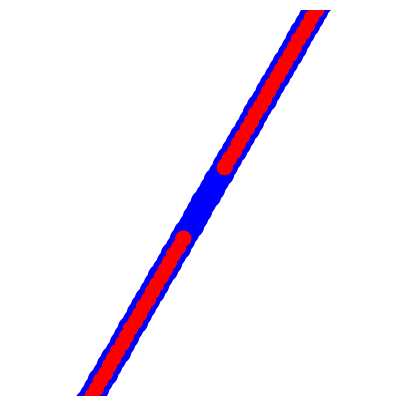

In [377]:
plt.figure(figsize=(5,5))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
ax.plot(X_proj2[:,0], X_proj2[:,1], '.b', label="Original attractor", alpha=1., markersize=35)
ax.plot(Xeps_proj2[:,0], Xeps_proj2[:,1], '.r', label="Stable", zorder=10, alpha=1., markersize=20)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
center_pca = pca.transform([center])[0]
ax.set(xlim=(center_pca[0]-4.5*b, center_pca[0]+4.5*b), ylim=(center_pca[1]-4.5*b, center_pca[1]+4.5*b))

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.),
#           fancybox=True, shadow=True, ncol=3, columnspacing=0.8, handletextpad=.3)

plt.savefig(currentdir+"/Stability/figures/noorman_ring_activity_localpert_zoom.pdf", bbox_inches="tight")
plt.savefig(currentdir+"/Stability/figures/noorman_ring_activity_localpert_zoom.png", bbox_inches="tight")

In [ ]:
hypersphere_points = b*uniform_hypersphere_lattice(n_points=10**3, n_dim=6)
hypersphere_points_proj = pca.transform(hypersphere_points)
plt.scatter(*hypersphere_points_proj.T) #looks like it's just a circle